[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/032_optimization/optimization.ipynb)

# Optimización

En este post vamos a ver algunas técnicas que podemos aplicar durante el entrenamiento de nuestras `redes neuronales` para acelerar el proceso de optimización y, potencialmente, obtener mejores resultados de los que hemos sido capaces de obtener hasta ahora. Compararemos estas técnicas en el mismo problema utilizado en el post anterior, la clasificación de imágenes con el dataset CIFAR10.

In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

In [74]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [76]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [77]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

## Optimizadores

Hasta este punto, hemos optimizado siempre nuestras redes neuronales con el algoritmo de `stochastic gradient descent`, el cual actualiza los pesos del modelo siguiente la regla $w \leftarrow w - \eta \, \, \frac{dl}{dw}$, dónde $w$ son los parámetros de la red neuronal, $\eta$ es el factor de aprendizaje (o *learning rate*) y $\frac{dl}{dw}$ es la derivada de la función de pérdida con respecto a los parámetros. Puedes aprender todo lo necesario sobre este algoritmo en est [post](https://sensioai.com/blog/013_perceptron2). Si bien este algoritmo funciona y en ocasiones es la mejor elección, existen otros algoritmos de optimización que pueden acelerar el entrenamiento requiriendo muchas menos epochs para alacanzar el mismo resultado, o para el mismo número de epochs encontrar un mejor solución.

![](https://camo.githubusercontent.com/7d81e76398258f79f1d31e59d1ba32575512c4b0/687474703a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f776173736e616d652f76697a5f746f7263685f6f7074696d2f6d61737465722f646f63732f766964656f732f6265616c65735f32303137313131375f30302d30322d32305f32642e676966)

### Momentum

La primera mejora que podemos hacer sobre el algoritmo *SGD* es añadir *momentum*. De la misma manera que una pelota rodando por una superficie inclinada acelera poco a poco debido a la fuerza de la gravedad (a esto se le llama ganar *momentum*) podemos hacer que nuestros pasos de `descenso por gradiente` sean más grandes si el signo del gradiente es el mismo durante *updates* consecutivos.

$$m \leftarrow \beta m - \eta \, \, \frac{dl}{dw}$$


$$w \leftarrow w + m$$

En `Pytorch` podemos controlar el valor de $\beta$ (cuanto *momentum* queremos añadir) con el parámetro `momentum`.

### RMSProp

El algoritmo del `descenso por gradiente` funciona intentando descender rápidamente en la dirección en la que el gradiente es mayor. Sin embargo, esta dirección no tiene porqué ser siempre la que indica el camino hacia el óptimo global. El algoritmo de optimización `RMSProp` intenta tener este factor en cuenta escalando el gradiente en la dimensión con mayor pendiente

$$ s \leftarrow \beta s + (1 - \beta) \frac{dl}{dw} ⊗ \frac{dl}{dw} $$

$$ w \leftarrow w - \eta \frac{dl}{dw} ⊘ \sqrt{s + \epsilon}$$

donde $\beta$ es el *decay rate* (normalmente 0.9) y $\epsilon$ es un valor pequeño para evitar división entre 0. En `Pytorch` podemos usar este optimizador con la clase `torch.optim.RMSProp`.

### Adam

Adam combina las ideas de *momentum* y *RMSProp*, y es la opción elegida por defecto por la mayoría de desarrolladores. 


$$m \leftarrow \beta_1 m - (1 - \beta_1) \, \, \frac{dl}{dw}$$
$$ s \leftarrow \beta_2 s + (1 - \beta_2) \frac{dl}{dw} ⊗ \frac{dl}{dw} $$
$$\hat{m} \leftarrow \frac{m}{1-\beta_1^T}$$
$$\hat{s} \leftarrow \frac{s}{1-\beta_2^T}$$
$$ w \leftarrow w + \eta \hat{m} ⊘ \sqrt{\hat{s} + \epsilon}$$

### Comparativa

Vamos a comparar los diferentes optimizadores presentados.

In [78]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.12370 en epoch 1
Mejor modelo guardado con acc 0.13850 en epoch 2
Mejor modelo guardado con acc 0.14870 en epoch 3
Mejor modelo guardado con acc 0.15080 en epoch 4
Mejor modelo guardado con acc 0.15720 en epoch 5
Mejor modelo guardado con acc 0.15980 en epoch 7
Mejor modelo guardado con acc 0.16170 en epoch 10
Epoch 10/100 loss 2.26554 acc 0.16959 val_loss 2.26611 val_acc 0.16170
Mejor modelo guardado con acc 0.16590 en epoch 11
Mejor modelo guardado con acc 0.17180 en epoch 13
Mejor modelo guardado con acc 0.17480 en epoch 15
Mejor modelo guardado con acc 0.17770 en epoch 16
Mejor modelo guardado con acc 0.18790 en epoch 17
Mejor modelo guardado con acc 0.19740 en epoch 18
Mejor modelo guardado con acc 0.20360 en epoch 19
Mejor modelo guardado con acc 0.21600 en epoch 20
Epoch 20/100 loss 2.17657 acc 0.21676 val_loss 2.17991 val_acc 0.21600
Mejor modelo guardado con acc 0.22410 en epoch 21
Mejor modelo guardado con acc 0.23900 en epoch 23
Mejor modelo g

In [79]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.19270 en epoch 1
Mejor modelo guardado con acc 0.20770 en epoch 2
Mejor modelo guardado con acc 0.26130 en epoch 3
Mejor modelo guardado con acc 0.27070 en epoch 5
Mejor modelo guardado con acc 0.30170 en epoch 6
Mejor modelo guardado con acc 0.30800 en epoch 8
Mejor modelo guardado con acc 0.32730 en epoch 9
Mejor modelo guardado con acc 0.33290 en epoch 10
Epoch 10/100 loss 1.82450 acc 0.34713 val_loss 1.88295 val_acc 0.33290
Mejor modelo guardado con acc 0.33550 en epoch 12
Mejor modelo guardado con acc 0.34260 en epoch 13
Mejor modelo guardado con acc 0.34920 en epoch 14
Mejor modelo guardado con acc 0.35790 en epoch 16
Mejor modelo guardado con acc 0.36350 en epoch 18
Mejor modelo guardado con acc 0.37200 en epoch 20
Epoch 20/100 loss 1.67252 acc 0.40565 val_loss 1.77857 val_acc 0.37200
Mejor modelo guardado con acc 0.37430 en epoch 21
Mejor modelo guardado con acc 0.38020 en epoch 25
Mejor modelo guardado con acc 0.38640 en epoch 29
Epoch 30/100 lo

In [80]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.18300 en epoch 1
Mejor modelo guardado con acc 0.20630 en epoch 2
Mejor modelo guardado con acc 0.26600 en epoch 3
Mejor modelo guardado con acc 0.30330 en epoch 4
Mejor modelo guardado con acc 0.30880 en epoch 5
Mejor modelo guardado con acc 0.35010 en epoch 6
Epoch 10/100 loss 1.66004 acc 0.40247 val_loss 2.08185 val_acc 0.30180
Mejor modelo guardado con acc 0.35110 en epoch 14
Mejor modelo guardado con acc 0.35930 en epoch 17
Mejor modelo guardado con acc 0.37390 en epoch 19
Epoch 20/100 loss 1.45913 acc 0.47631 val_loss 1.90266 val_acc 0.33640
Mejor modelo guardado con acc 0.38510 en epoch 29
Epoch 30/100 loss 1.29273 acc 0.53065 val_loss 2.00769 val_acc 0.35450
Mejor modelo guardado con acc 0.39290 en epoch 38
Epoch 40/100 loss 1.15354 acc 0.58061 val_loss 2.05333 val_acc 0.36470
Epoch 50/100 loss 1.03692 acc 0.61963 val_loss 2.24867 val_acc 0.36850
Mejor modelo guardado con acc 0.39430 en epoch 54
Epoch 60/100 loss 0.93936 acc 0.65764 val_loss 2.37

In [81]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.28860 en epoch 1
Mejor modelo guardado con acc 0.30390 en epoch 2
Mejor modelo guardado con acc 0.32790 en epoch 3
Mejor modelo guardado con acc 0.35170 en epoch 4
Mejor modelo guardado con acc 0.35320 en epoch 5
Mejor modelo guardado con acc 0.37170 en epoch 6
Mejor modelo guardado con acc 0.37850 en epoch 9
Epoch 10/100 loss 1.56814 acc 0.43889 val_loss 1.82799 val_acc 0.34910
Mejor modelo guardado con acc 0.38770 en epoch 14
Mejor modelo guardado con acc 0.39360 en epoch 15
Mejor modelo guardado con acc 0.39800 en epoch 16
Mejor modelo guardado con acc 0.40610 en epoch 19
Epoch 20/100 loss 1.35851 acc 0.51334 val_loss 1.74592 val_acc 0.40580
Mejor modelo guardado con acc 0.41220 en epoch 21
Epoch 30/100 loss 1.13612 acc 0.59355 val_loss 1.85074 val_acc 0.40530
Epoch 40/100 loss 0.95292 acc 0.65685 val_loss 2.05072 val_acc 0.39200
Epoch 50/100 loss 0.82711 acc 0.69705 val_loss 2.31110 val_acc 0.39000
Epoch 60/100 loss 0.70743 acc 0.75478 val_loss 2.483

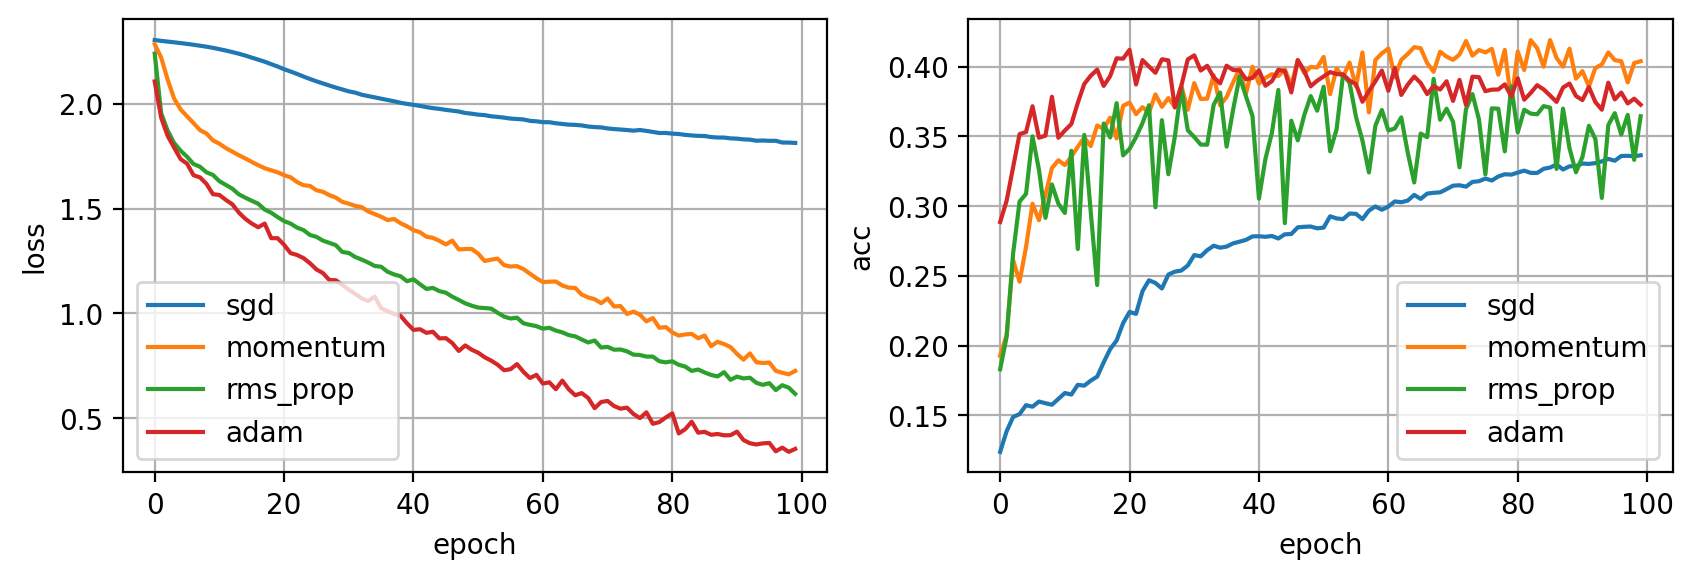

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes ver, las variantes de *SGD* son capaces de converger mucho más rápido. Aún así, si le damos suficiente tiempo, *SGD* es capaz de llegar a los mismos resultados, e incluso superarlos. Existen muchos otros optimizadores, sin embargo los vistos aquí son los más comunes.

## *Learning Rate Scheduling* 

Otra técninca muy utilizada para acelerar el proceso de entrenamiento de una `red neuronal` es el *learning rate scheduling* y consiste en ir variando el factor de aprendizaje durante el entrenamiento en vez de utilizar un valor fijo. Un valor alto del *learning rate* nos puede dar una ventaja en las fases iniciales del entrenamiento, en las que queremos acercarnos al punto óptimo de manera rápida. Aun así, no nos permitirá llegar al mejor valor posible ya que se quedará oscilando alrededor. En este punto, un learning rate pequeño nos permitiría acercarnos mucho más al valor óptimo, pero tardaría mucho en llegar en primer lugar. 

![](https://camo.githubusercontent.com/051fc8fa68156d721512278e397dab5680dad77a/687474703a2f2f63733233316e2e6769746875622e696f2f6173736574732f6e6e332f6c6561726e696e6772617465732e6a706567)

La idea es combinar varios valores de *learning rate* para aprovechar las ventajas de cada uno en diferentes partes del entrenamiento. `Pytorch` nos ofrece algunos *schedulers* populares que podemos usar en el paquete `torch.optim.lr_scheduler`. Vamos a ver algunos ejemplos.

In [83]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [84]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# multiplica el lr por 0.1 cada 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.24700 en epoch 1
Mejor modelo guardado con acc 0.27330 en epoch 2
Mejor modelo guardado con acc 0.32310 en epoch 3
Mejor modelo guardado con acc 0.33200 en epoch 4
Mejor modelo guardado con acc 0.35170 en epoch 7
Mejor modelo guardado con acc 0.36070 en epoch 9
Mejor modelo guardado con acc 0.36610 en epoch 10
Epoch 10/30 loss 1.62382 acc 0.41899 val_loss 1.80690 val_acc 0.36610 lr 0.01000
Mejor modelo guardado con acc 0.39920 en epoch 11
Mejor modelo guardado con acc 0.40170 en epoch 13
Mejor modelo guardado con acc 0.40250 en epoch 15
Mejor modelo guardado con acc 0.40450 en epoch 16
Mejor modelo guardado con acc 0.40600 en epoch 17
Mejor modelo guardado con acc 0.40740 en epoch 19
Epoch 20/30 loss 1.38708 acc 0.50060 val_loss 1.71555 val_acc 0.40360 lr 0.00100
Mejor modelo guardado con acc 0.40980 en epoch 21
Mejor modelo guardado con acc 0.41160 en epoch 23
Mejor modelo guardado con acc 0.41170 en epoch 26
Epoch 30/30 loss 1.34885 acc 0.52090 val_los

In [85]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.10380 en epoch 1
Mejor modelo guardado con acc 0.21130 en epoch 2
Mejor modelo guardado con acc 0.26720 en epoch 3
Mejor modelo guardado con acc 0.28600 en epoch 4
Mejor modelo guardado con acc 0.31610 en epoch 5
Mejor modelo guardado con acc 0.33050 en epoch 7
Mejor modelo guardado con acc 0.35520 en epoch 8
Mejor modelo guardado con acc 0.36330 en epoch 9
Epoch 10/30 loss 1.67725 acc 0.39291 val_loss 2.06377 val_acc 0.30190 lr 0.00842
Mejor modelo guardado con acc 0.38350 en epoch 13
Mejor modelo guardado con acc 0.39560 en epoch 15
Mejor modelo guardado con acc 0.39990 en epoch 17
Mejor modelo guardado con acc 0.41280 en epoch 20
Epoch 20/30 loss 1.39944 acc 0.48985 val_loss 1.67288 val_acc 0.41280 lr 0.00446
Mejor modelo guardado con acc 0.41420 en epoch 23
Mejor modelo guardado con acc 0.41470 en epoch 25
Mejor modelo guardado con acc 0.41910 en epoch 27
Mejor modelo guardado con acc 0.42050 en epoch 29
Mejor modelo guardado con acc 0.42670 en epoch

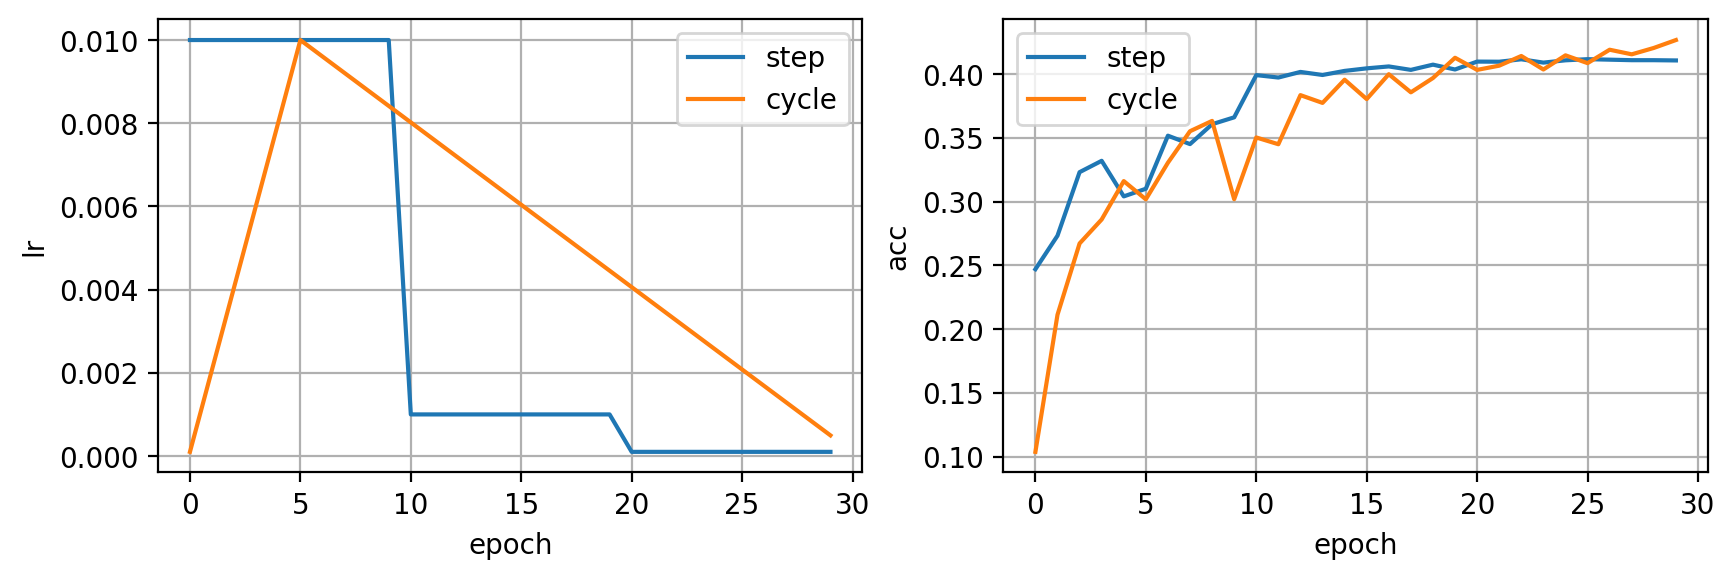

In [86]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Normalización

Otra técnica muy importante para acelerar el entrenamiento consiste en normalizar nuestros datos. Esto es algo de lo que ya hemos hablado en posts anteriores, y en este mismo post puedes ver como al principio de todo hemos dividido nuestras imágenes entre 255 de manera que los valores presentes en los tensores que nuestra `red neuronal` usa como entradas estén normalizados entre 0 y 1. Otra normalización popular, cuando trabajamos con imágenes, consiste en calcular el valor medio y desviación estándar de nuestro dataset, y normalizar las imágenes para que tengan media 0 y desviación estándar 1.

In [87]:
import numpy as np

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [88]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-1.62320331e-11, -2.54226058e-11, -5.44383358e-11]),
 array([1., 1., 1.]))

In [89]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:40000], train_images_norm[40000:], train_images_norm[:5000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [92]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset_norm['train']), len(dataset_norm['val'])

(5000, 10000)

In [93]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

Mejor modelo guardado con acc 0.17480 en epoch 1
Mejor modelo guardado con acc 0.21580 en epoch 2
Mejor modelo guardado con acc 0.26480 en epoch 3
Mejor modelo guardado con acc 0.27220 en epoch 4
Mejor modelo guardado con acc 0.27530 en epoch 5
Mejor modelo guardado con acc 0.30910 en epoch 6
Mejor modelo guardado con acc 0.31190 en epoch 7
Mejor modelo guardado con acc 0.31620 en epoch 8
Mejor modelo guardado con acc 0.32610 en epoch 9
Mejor modelo guardado con acc 0.32870 en epoch 10
Epoch 10/100 loss 1.83331 acc 0.34236 val_loss 1.88809 val_acc 0.32870 lr 0.00100
Mejor modelo guardado con acc 0.33680 en epoch 12
Mejor modelo guardado con acc 0.33880 en epoch 13
Mejor modelo guardado con acc 0.35510 en epoch 14
Mejor modelo guardado con acc 0.36120 en epoch 18
Mejor modelo guardado con acc 0.36190 en epoch 19
Epoch 20/100 loss 1.69124 acc 0.39889 val_loss 1.80513 val_acc 0.35460 lr 0.00100
Mejor modelo guardado con acc 0.36260 en epoch 21
Mejor modelo guardado con acc 0.36590 en epoc

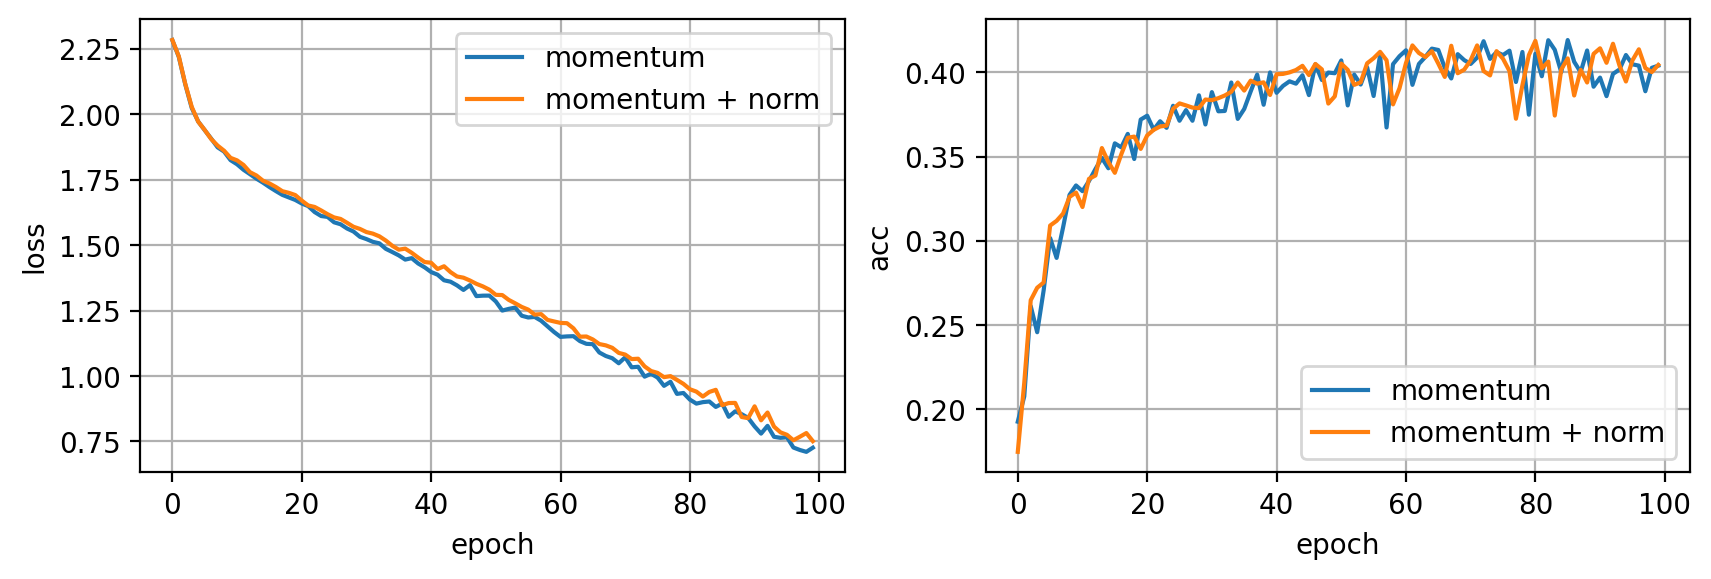

In [94]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

En este caso, el efecto de la normalización no es considerable (al trabajar con imágenes éste suele ser el caso).

### *Batch Normalization*

Otra forma de normalización muy importante que puede acelerar de manera dramática el entrenamiento es el *batch norm*. Podemos añadir esta capa en nuestras redes y su objetivo será el de normalizar sus entradas para que tengan media cero y desviación estándar 1. Además, aprenderá unos parámetros que le permitirán escalar y mover estos valores normalizados para mejorar sus representación, facilitando a la `red neuronal` la tarea de clasificación.

$$ \mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} x^{(i)} $$
$$ \sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (x^{(i)} - \mu_B) $$
$$\hat{x}^{(i)} = \frac{x^{(i)} - \mu_b}{\sqrt{\sigma_B^2 + \epsilon}} $$ 
$$z^{(i)} = \gamma ⊗ \hat{x}^{(i)} + \beta $$ 

In [95]:
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [96]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.34140 en epoch 1
Mejor modelo guardado con acc 0.37400 en epoch 2
Mejor modelo guardado con acc 0.38840 en epoch 4
Epoch 10/100 loss 1.15359 acc 0.61823 val_loss 1.91716 val_acc 0.36150 lr 0.00100
Epoch 20/100 loss 0.66286 acc 0.79598 val_loss 2.55254 val_acc 0.31990 lr 0.00100
Epoch 30/100 loss 0.41620 acc 0.87301 val_loss 2.71636 val_acc 0.33780 lr 0.00100
Epoch 40/100 loss 0.22863 acc 0.93591 val_loss 2.93232 val_acc 0.34100 lr 0.00100
Epoch 50/100 loss 0.22788 acc 0.93491 val_loss 3.49248 val_acc 0.32090 lr 0.00100
Epoch 60/100 loss 0.09998 acc 0.97830 val_loss 3.12779 val_acc 0.37450 lr 0.00100
Epoch 70/100 loss 0.13395 acc 0.96178 val_loss 3.28832 val_acc 0.35320 lr 0.00100
Epoch 80/100 loss 0.07070 acc 0.98209 val_loss 3.46042 val_acc 0.36170 lr 0.00100
Epoch 90/100 loss 0.07542 acc 0.98089 val_loss 3.30705 val_acc 0.38020 lr 0.00100
Epoch 100/100 loss 0.08828 acc 0.97552 val_loss 3.40280 val_acc 0.35930 lr 0.00100


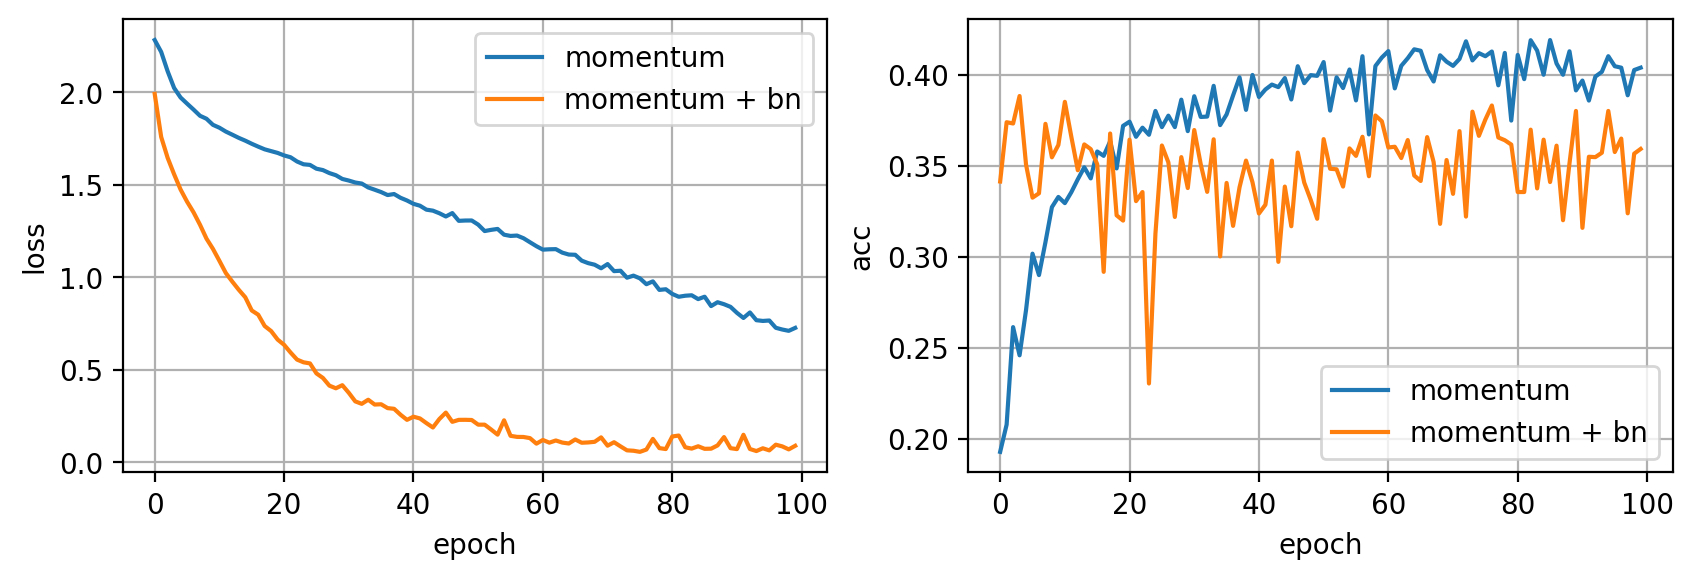

In [97]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes observar, la introducción de la capa *Batch Norm* acelera muchísimo el entrenamiento, resultando en una reducción de la función de pérdida mucho más rápida (haciendo que nuestro modelo haga *overfitting* mucho más pronto). Combinando esta capa con alguna forma de [regularización](https://sensioai.com/blog/031_regularization), como por ejemplo *data augmentation* y *early stopping*, obtendremos buenos modelos capaces de generalizar de manera rápida.

## *Transfer Learning*

Posiblemente la técnica más interesante para acelerar el entrenamiento de un modelo es el *transfer learning*. No solo nos permite entrenar una red más rápido si no que además nos lo permite hacer con menos datos. Esta técnica consiste en utilizar una red ya entrenada en algún dataset como punto de partida para nuestro entrenamiento. Si nuestro dataset no es muy diferente al dataset utilizado originalmente para entrenar la red, es posible que podamos "transferir" el conocimiento que ya posee a nuestro caso. En la práctica, esta técnica funciona muy bien y nosotros la utilizaremos de manera extensiva en nuestras aplicaciones de ahora en adelante. En futuros posts entraremos en detalle en cómo aplicar transfer learning.

## Resumen 

En este post hemos presentado varias técnicas para acelerar el proceso de entrenamiento de una `red neuronal`. Combinando estas técnicas con las presentadas en los posts anteriores seremos capaces de entrenar modelos con buenas prestaciones de forma rápida. Hemos visto como podemos mejorar nuestro optimizador *SGD* para acelerar el proceso de optimización, también que podemos ir variando el *learning rate* durante el entrenamiento. La normalización de los datos y el uso de la capa *Batch Norm* también nos aportarán una aceleración considerable. Y, por último, si podemos usar una red preentrenada en una tarea similar a la nuestra seremos capaces de obtener un buen modelo de manera rápida y con pocos datos gracias al *transfer learning*. En el próximo post encontrarás una receta en la que combinamos todas las técnicas vistas y que puedes seguir para empezar a entrenar tus redes de forma efectiva.